# Semi-superviesd GAN (SGAN)

We can compare the effectivess of unlabeled data. <br>

First, we train the MNIST dataset with only 100 (=num_labeled) data as the labeled dataset and the other data as the unlabeled dataset. <br>

Then, we train only supervised data and compare the performance.


In [1]:
# check the GPU usage
!nvidia-smi

Sat Dec 19 11:36:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   29C    P8     8W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras import backend as K

from keras.datasets import mnist
from keras.layers import (Activation, BatchNormalization, Concatenate, Dense,
                          Dropout, Flatten, Input, Lambda, Reshape)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical

## Setup Dataset

We used MNIST dataset again.
This time, we use limited number of labeled data for supervised training and the remainders for unsupervised training.


In [3]:
# Number of labeled examples to use (rest will be used as unlabeled)
num_labeled = 100

In [4]:
class Dataset:
    def __init__(self, num_labeled):

        # Number labeled examples to use for training
        self.num_labeled = num_labeled

        # Load the MNIST dataset
        (self.x_train, self.y_train), (self.x_test,
                                       self.y_test) = mnist.load_data()

        def preprocess_imgs(x):
            # Rescale [0, 255] grayscale pixel values to [-1, 1]
            x = (x.astype(np.float32) - 127.5) / 127.5
            # Expand image dimensions to width x height x channels
            x = np.expand_dims(x, axis=3)
            return x

        def preprocess_labels(y):
            return y.reshape(-1, 1)

        # Training data
        self.x_train = preprocess_imgs(self.x_train)
        self.y_train = preprocess_labels(self.y_train)

        # Testing data
        self.x_test = preprocess_imgs(self.x_test)
        self.y_test = preprocess_labels(self.y_test)

    def batch_labeled(self, batch_size):
        # Get a random batch of labeled images and their labels
        idx = np.random.randint(0, self.num_labeled, batch_size)
        imgs = self.x_train[idx]
        labels = self.y_train[idx]
        return imgs, labels

    def batch_unlabeled(self, batch_size):
        # Get a random batch of unlabeled images
        idx = np.random.randint(self.num_labeled, self.x_train.shape[0],
                                batch_size)
        imgs = self.x_train[idx]
        return imgs

    def training_set(self):
        x_train = self.x_train[range(self.num_labeled)]
        y_train = self.y_train[range(self.num_labeled)]
        return x_train, y_train

    def test_set(self):
        return self.x_test, self.y_test

# form dataset
dataset = Dataset(num_labeled)

11493376/11490434 [==============================] - 0s 0us/step


## Set overall settings

In [5]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

# Number of classes in the dataset
num_classes = 10

## Set up a Generator

Same with our DCGAN built before! <br>

 input(100)-FC(7x7x256)-BN-LReLU-FC(7x7x128)-BN-LReLU-Tconv(14x14x64)-BN-LReLU-Tconv(28x28x1)-tanh-output(28x28).

In [6]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 7x7x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=5, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer, from 7x7x128 into 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

    # Transposed convolution layer, from 14x14x64 into 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## Discriminator
The basic architcture of the discriminator is same with our pervious DCGAN. <br>

But this time, the number of the output is changed to that of classes.

input(28x28x1)-conv(14x14x64)-LReLU-Drop-conv(7x7x128)-LReLU-Drop-output(10)

In [7]:
def build_discriminator_net(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x64 tensor
    model.add(
        Conv2D(64, kernel_size=5, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    # Convolutional layer, from 14x14x64 into 7x7x128 tensor
    model.add(
        Conv2D(128, kernel_size=5, strides=2, input_shape=img_shape, padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.3))

    # Output layer with sigmoid activation
    model.add(Flatten())

    # Fully connected layer with num_classes neurons
    model.add(Dense(num_classes))

   # in former DCGAN model 
   #model.add(Dense(1, activation='sigmoid')) 

    return model

### Additional setting for discriminator (for supervised input)
For supervised data, softmax activation is used. 

In [8]:
def build_discriminator_supervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    # Softmax activation, giving predicted probability distribution over the real classes
    model.add(Activation('softmax'))

    return model

### Additional setting for discriminator (for unsupervised input)
For supervised data, softmax activation is used. 

Convert raw $N$ outputs (x) to the probability for "real" data.<br>
If the sum of the outputs is large, it is considered to be real  (prediction -> 1).

In [9]:
def build_discriminator_unsupervised(discriminator_net):

    model = Sequential()

    model.add(discriminator_net)

    def predict(x):
        # Transform distribution over real N (10) classes into a binary real-vs-fake probability
        prediction = 1.0 - (1.0 /
                            (K.sum(K.exp(x), axis=-1, keepdims=True) + 1.0))
        return prediction

    # 'Real-vs-fake' output neuron defined above
    model.add(Lambda(predict))

    return model

## Build the GAN model

same as before.

In [10]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

### Discriminator

We used different loss function for each supervised and unsupervised data.

In [11]:
# Core Discriminator network:
# These layers are shared during supervised and unsupervised training
discriminator_net = build_discriminator_net(img_shape)

# Build & compile the Discriminator for supervised training
discriminator_supervised = build_discriminator_supervised(discriminator_net)
discriminator_supervised.compile(loss='categorical_crossentropy',
                                 metrics=['accuracy'],
                                 optimizer=Adam())

# Build & compile the Discriminator for unsupervised training
discriminator_unsupervised = build_discriminator_unsupervised(discriminator_net)
discriminator_unsupervised.compile(loss='binary_crossentropy',
                                   optimizer=Adam())

##### Just for reference  (DCGAN for comparison) #####
#discriminator = build_discriminator(img_shape)
#discriminator.compile(loss='binary_crossentropy',
#                      optimizer=Adam(),
#                      metrics=['accuracy'])

## Generator


In [12]:
# Build the Generator
generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
discriminator_unsupervised.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
# Note that we are using the Discriminator version with unsupervised output
gan = build_gan(generator, discriminator_unsupervised)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

####### Just for reference  (DCGAN for comparison) #####
## Build the Generator
#generator = build_generator(z_dim)

# Keep Discriminator’s parameters constant for Generator training
#discriminator.trainable = False

# Build and compile GAN model with fixed Discriminator to train the Generator
#gan = build_gan(generator, discriminator)
#gan.compile(loss='binary_crossentropy', optimizer=Adam())

### Overview of the model

In [13]:
discriminator_supervised.summary()
discriminator_unsupervised.summary()
generator.summary()
gan.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                269322    
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 269,322
Trainable params: 0
Non-trainable params: 269,322
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 10)                269322    
_________________________________________________________________
lambda (Lambda)              (None, 1)                 0         
Total params: 269,322
Trainable params: 0
Non-trainable params: 269,322
_________________________________________________________________
Model: "sequential_3

## Preparation for the training

In [14]:
supervised_losses = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval):

    # Labels for real images: all ones
    real = np.ones((batch_size, 1))

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get labeled examples
        imgs, labels = dataset.batch_labeled(batch_size)

        # One-hot encode labels
        labels = to_categorical(labels, num_classes=num_classes)

        # Get unlabeled examples
        imgs_unlabeled = dataset.batch_unlabeled(batch_size)

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train on real labeled examples
        d_loss_supervised, accuracy = discriminator_supervised.train_on_batch(imgs, labels)

        # Train on real unlabeled examples
        d_loss_real = discriminator_unsupervised.train_on_batch(
            imgs_unlabeled, real)

        # Train on fake examples
        d_loss_fake = discriminator_unsupervised.train_on_batch(gen_imgs, fake)

        d_loss_unsupervised = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        # Train Generator
        g_loss = gan.train_on_batch(z, np.ones((batch_size, 1)))

        if (iteration + 1) % sample_interval == 0:

            # Save Discriminator supervised classification loss to be plotted after training
            supervised_losses.append(d_loss_supervised)
            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print(
                "%d [D loss supervised: %.4f, acc.: %.2f%%] [D loss unsupervised: %.4f] [G loss: %f]"
                % (iteration + 1, d_loss_supervised, 100 * accuracy,
                   d_loss_unsupervised, g_loss))

### Train the model and investigate output 

In [15]:
# Set hyperparameters
iterations = 8000
batch_size = 32
sample_interval = 800

# Train the SGAN for the specified number of iterations
train(iterations, batch_size, sample_interval)

800 [D loss supervised: 0.0041, acc.: 100.00%] [D loss unsupervised: 0.1538] [G loss: 4.014009]
1600 [D loss supervised: 0.0027, acc.: 100.00%] [D loss unsupervised: 0.4086] [G loss: 2.185991]
2400 [D loss supervised: 0.0045, acc.: 100.00%] [D loss unsupervised: 0.5251] [G loss: 2.155874]
3200 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.3513] [G loss: 2.784251]
4000 [D loss supervised: 0.0008, acc.: 100.00%] [D loss unsupervised: 0.5527] [G loss: 2.661509]
4800 [D loss supervised: 0.0007, acc.: 100.00%] [D loss unsupervised: 0.2540] [G loss: 2.263368]
5600 [D loss supervised: 0.0003, acc.: 100.00%] [D loss unsupervised: 0.3453] [G loss: 3.005361]
6400 [D loss supervised: 0.0002, acc.: 100.00%] [D loss unsupervised: 0.4946] [G loss: 2.153570]
7200 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.3667] [G loss: 1.879787]
8000 [D loss supervised: 0.0001, acc.: 100.00%] [D loss unsupervised: 0.4413] [G loss: 2.099496]


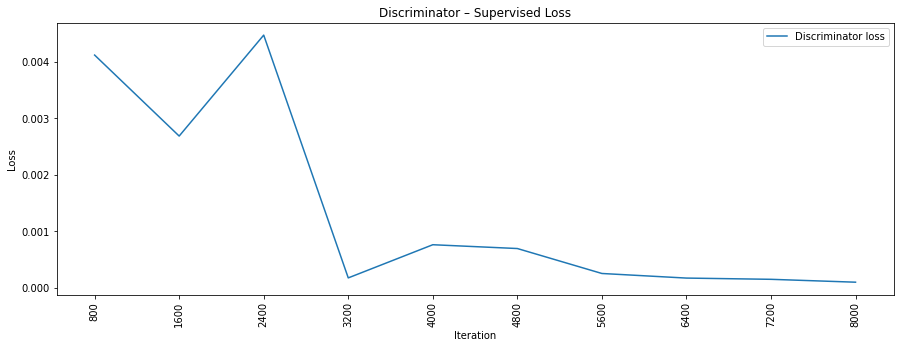

In [16]:
losses = np.array(supervised_losses)

# Plot Discriminator supervised loss
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses, label="Discriminator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Discriminator – Supervised Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

## Evaluation of SGAN  - Training and Test Accuracy

In [17]:
## Training Accuracy
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 7ms/step - loss: 2.3363e-05 - accuracy: 1.0000
Training Accuracy: 100.00%


In [18]:
## Test Accuracy
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = discriminator_supervised.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 0.5550 - accuracy: 0.8752
Test Accuracy: 87.52%


## Fully supervised classifier
##  - Do not use unlabeled data -



In [24]:
# Fully supervised classifier with the same network architecture as the SGAN Discriminator
mnist_classifier = build_discriminator_supervised(build_discriminator_net(img_shape))
mnist_classifier.compile(loss='categorical_crossentropy',
                         metrics=['accuracy'],
                         optimizer=Adam())

In [25]:
imgs, labels = dataset.training_set()

# One-hot encode labels
labels = to_categorical(labels, num_classes=num_classes)

# Train the classifier
training = mnist_classifier.fit(x=imgs,
                                y=labels,
                                batch_size=32,
                                epochs=30,
                                verbose=1)
losses = training.history['loss']
accuracies = training.history['accuracy']

Epoch 1/30
4/4 [==============================] - 1s 5ms/step - loss: 2.3171 - accuracy: 0.1108
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 1.9651 - accuracy: 0.3579
Epoch 3/30
4/4 [==============================] - 0s 4ms/step - loss: 1.7385 - accuracy: 0.3462
Epoch 4/30
4/4 [==============================] - 0s 5ms/step - loss: 1.3163 - accuracy: 0.7333
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 0.9057 - accuracy: 0.7877
Epoch 6/30
4/4 [==============================] - 0s 4ms/step - loss: 0.5368 - accuracy: 0.9039
Epoch 7/30
4/4 [==============================] - 0s 4ms/step - loss: 0.3914 - accuracy: 0.9015
Epoch 8/30
4/4 [==============================] - 0s 4ms/step - loss: 0.2498 - accuracy: 0.9418
Epoch 9/30
4/4 [==============================] - 0s 4ms/step - loss: 0.1612 - accuracy: 0.9654
Epoch 10/30
4/4 [==============================] - 0s 5ms/step - loss: 0.0984 - accuracy: 0.9847
Epoch 11/30
4/4 [======================

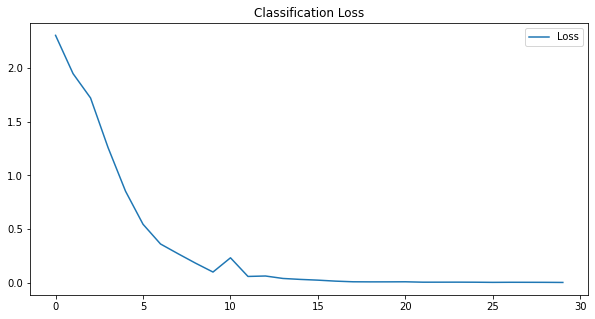

In [26]:
# Plot classification loss
plt.figure(figsize=(10, 5))
plt.plot(np.array(losses), label="Loss")
plt.title("Classification Loss")
plt.legend()

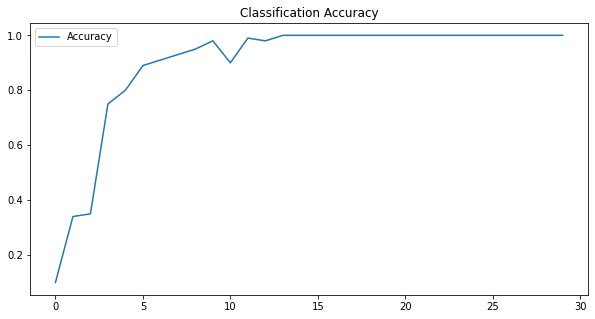

In [27]:
# Plot classification accuracy
plt.figure(figsize=(10, 5))
plt.plot(np.array(accuracies), label="Accuracy")
plt.title("Classification Accuracy on labeled dataset")
plt.legend()

In [28]:
## Training Accuracy
x, y = dataset.training_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the training set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Training Accuracy: %.2f%%" % (100 * accuracy))

4/4 [==============================] - 0s 3ms/step - loss: 0.0013 - accuracy: 1.0000
Training Accuracy: 100.00%


In [29]:
## Test Accuracy
x, y = dataset.test_set()
y = to_categorical(y, num_classes=num_classes)

# Compute classification accuracy on the test set
_, accuracy = mnist_classifier.evaluate(x, y)
print("Test Accuracy: %.2f%%" % (100 * accuracy))

313/313 [==============================] - 1s 3ms/step - loss: 1.3187 - accuracy: 0.7188
Test Accuracy: 71.88%
